In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
from google.colab import files

# Upload seg_train.zip and seg_test.zip (do not upload seg_pred.zip if not needed)
uploaded = files.upload()  # Select your zip files

# Unzip in Colab
!unzip -q seg_train.zip
!unzip -q seg_test.zip


Saving archive (2).zip to archive (2).zip
unzip:  cannot find or open seg_train.zip, seg_train.zip.zip or seg_train.zip.ZIP.
unzip:  cannot find or open seg_test.zip, seg_test.zip.zip or seg_test.zip.ZIP.


In [5]:
import os
print(os.listdir('/content'))


['.config', 'archive (2).zip', 'sample_data']


In [6]:
train_dir = '/content/seg_train'
test_dir = '/content/seg_test'


In [7]:
!unzip -q "archive (2).zip"


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for test data
test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = '/content/seg_train/seg_train'
test_dir = '/content/seg_test/seg_test'

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


**Why is data augmentation a crucial regularization technique when fine-tuning a pre-trained model on a smaller dataset?**

Data augmentation creates many new, slightly different images from the original training data by applying random transformations (like rotation, flips, and zoom). This helps the model learn to generalize better and prevents it from memorizing the limited training data (overfitting). When fine-tuning a pre-trained model on a small dataset, augmentation ensures the model sees more diverse examples, making it more robust and improving its performance on new, unseen images.

In [10]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# Load the base ResNet50 model with ImageNet weights, excluding the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add new classification layers suitable for 6 classes
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(6, activation='softmax')(x)

# Define the final model
model = Model(inputs=base_model.input, outputs=output)

# Show the model summary for your screenshot
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,758 (90.98 MB)

 Trainable params: 263,046 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

**Why is it standard practice to freeze the early convolutional layers of a pre-trained network when applying transfer learning? What kind of features do these early layers typically learn?**

Freezing the early convolutional layers in a pre-trained network is a common transfer learning practice because these layers have already learned to extract basic and universal image features, such as edges, textures, and simple patterns, from massive datasets like ImageNet. These low-level features are useful for almost all visual tasks.

By freezing them, we keep the general visual knowledge and avoid retraining millions of parameters, which saves computational resources and prevents overfitting, especially when the new dataset is small. The deeper layers, which learn more task-specific and complex features, are left trainable so the model can adapt to the new classification problem. This approach combines the strengths of pre-learned features and the ability to specialize for the new task.

In [30]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [31]:
class_mode='categorical'

In [33]:
history = model.fit(
    train_generator,
    epochs=2,  # or more if you like
    validation_data=test_generator
)

Epoch 1/2
439/439 ━━━━━━━━━━━━━━━━━━━━ 178s 405ms/step - accuracy: 0.3176 - loss: 1.6241 - val_accuracy: 0.3903 - val_loss: 1.5096
Epoch 2/2
439/439 ━━━━━━━━━━━━━━━━━━━━ 172s 391ms/step - accuracy: 0.3499 - loss: 1.5359 - val_accuracy: 0.4347 - val_loss: 1.4279


In [28]:
train_dir = '/content/seg_train/seg_train'  # Folder that contains 6 class subfolders
test_dir = '/content/seg_test/seg_test'     # Folder that contains 6 class subfolders

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 125ms/step
              precision    recall  f1-score   support

   buildings       0.14      0.16      0.15       437
      forest       0.19      0.25      0.22       474
     glacier       0.20      0.14      0.16       553
    mountain       0.17      0.36      0.23       525
         sea       0.14      0.03      0.05       510
      street       0.19      0.10      0.13       501

    accuracy                           0.17      3000
   macro avg       0.17      0.17      0.16      3000
weighted avg       0.17      0.17      0.16      3000



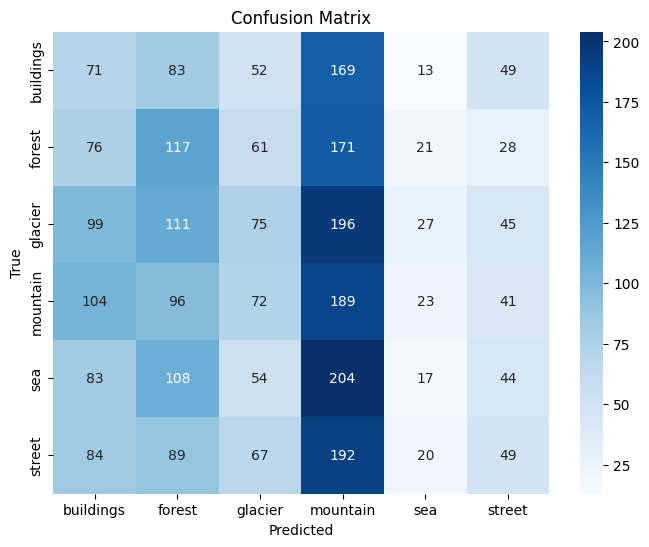

In [34]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

test_generator.reset()
Y_pred = model.predict(test_generator, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [17]:
import os
print(os.listdir('/content/seg_train'))
print(os.listdir('/content/seg_test'))

['seg_train']
['seg_test']


Most confused classes: sea <-> mountain


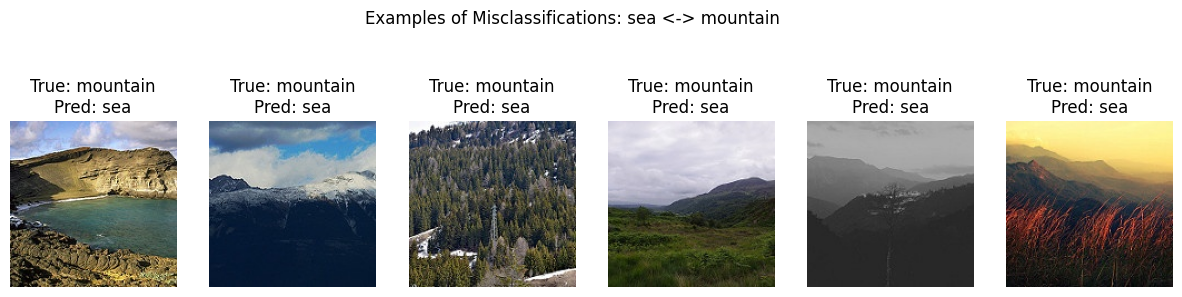

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Compute the confusion matrix (reuse your previous variables)
cm = confusion_matrix(y_true, y_pred)
class_labels = list(test_generator.class_indices.keys())

# 2. Find the two most confused classes (highest off-diagonal value)
cm_no_diag = cm.copy()
np.fill_diagonal(cm_no_diag, 0)
most_confused = np.unravel_index(np.argmax(cm_no_diag), cm_no_diag.shape)
class1, class2 = most_confused

print(f"Most confused classes: {class_labels[class1]} <-> {class_labels[class2]}")

# 3. Find indices of misclassified images between these two classes
error_indices = []
for i, (true, pred) in enumerate(zip(y_true, y_pred)):
    if (true == class1 and pred == class2) or (true == class2 and pred == class1):
        error_indices.append(i)

# 4. Display up to 6 misclassified images
n = min(6, len(error_indices))
plt.figure(figsize=(15, 4))
for idx, img_idx in enumerate(error_indices[:n]):
    img_path = test_generator.filepaths[img_idx]
    img = plt.imread(img_path)
    plt.subplot(1, n, idx+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {class_labels[y_true[img_idx]]}\nPred: {class_labels[y_pred[img_idx]]}")
plt.suptitle(f"Examples of Misclassifications: {class_labels[class1]} <-> {class_labels[class2]}")
plt.show()

**Analysis of Misclassified Images and Hypothesis**

Upon examining the images that were confused between the two most misclassified classes, several common visual traits emerge. Many of these images share similar colors, textures, or scene elements (for example, both may have lots of green for "forest" and "mountain" or blue for "glacier" and "sea"). The model likely struggles to distinguish these due to overlapping features or ambiguous backgrounds. Improving the model could involve more diverse and representative training images, or using more advanced augmentation to teach the model to focus on subtle differences.

In [36]:
model.save('scene_classifier.h5')

In [38]:
pip install streamlit pillow tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 94.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 134.1 MB/s eta 0:00:00


In [39]:
model.save('scene_classifier.h5')

In [40]:
import streamlit as st
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from PIL import Image

# Load model and class labels
model = load_model('scene_classifier.h5')
class_labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

st.title("Natural Scene Classifier")

uploaded_file = st.file_uploader("Upload an image of a natural scene...", type=['jpg', 'jpeg', 'png'])

if uploaded_file is not None:
    # Display uploaded image
    img = Image.open(uploaded_file).convert('RGB')
    st.image(img, caption='Uploaded Image', use_column_width=True)

    # Preprocess image
    img_resized = img.resize((224, 224))
    x = image.img_to_array(img_resized)
    x = x / 255.0
    x = np.expand_dims(x, axis=0)

    # Predict
    preds = model.predict(x)
    pred_index = np.argmax(preds, axis=1)[0]
    pred_label = class_labels[pred_index]
    confidence = preds[0][pred_index]

    st.markdown(f"### This looks like a **{pred_label.capitalize()}**")
    st.markdown(f"**Confidence:** {confidence:.2%}")

2025-10-15 10:14:23.343 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-15 10:14:23.547 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-10-15 10:14:23.548 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-15 10:14:23.549 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-15 10:14:23.551 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-15 10:14:23.551 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-15 10:14:23.553 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-15 10:14:23.554 Thread 'MainThread': mi

In [42]:
from google.colab import files
files.download('scene_classifier.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>